# **シンプルなブレンディングを試してみる**

### **必要な関数・ライブラリ**

In [140]:
# データ加工・処理・分析モジュール
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model

import os
import random

%matplotlib inline

import time

In [141]:
def set_time(dataframe, col_name):
    '''
    to_datetimeを使うための前処理
    '''
    dataframe[col_name] = dataframe[col_name].map(lambda x : transform_time(x))
    return dataframe

In [142]:
def add_time_sincos(input_data, key="datetime"):
    '''
    時間や月のデータを加える
    '''
    input_data['hour'] = input_data['datetime'].map(lambda x: int(x.hour))
    input_data['minute'] = input_data['datetime'].map(lambda x: int(x.minute))
    input_data['month'] = input_data['datetime'].map(lambda x: int(x.month))
    input_data['month_cos'] = input_data['month'].map(lambda x: np.cos(np.pi * x / 12))
    input_data['month_sin'] = input_data['month'].map(lambda x: np.sin(np.pi * x / 12))
    input_data['hour_cos'] = input_data['hour'].map(lambda x: np.cos(np.pi * x / 24))
    input_data['hour_sin'] = input_data['hour'].map(lambda x: np.sin(np.pi * x / 24))
    input_data['year'] = input_data['datetime'].map(lambda x: int(x.year))
    input_data = input_data.drop(['hour', 'month', 'minute'], axis=1)
    return input_data

In [143]:
def transform_time(x):
    '''
    set_time内で使う関数
    to_datetimeで24時をサポートしないので00に変更する処理
    '''
    str_x = str(x)
    res = ''
    if str(x)[8:10] == '24':
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' 00:'+str_x[10:12] 
    else:
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' '+ str_x[8:10] +':'+str_x[10:12]
    return res

In [144]:
def drop_nan(X, Y):
    '''
    正解データがnanであるデータの組を削除
    '''
    mask = np.isnan(Y)
    X = X[~mask]
    Y = Y[~mask]
    return X, Y

In [145]:
def to_zero(prediction):
    '''
    2012年から2015年の間で一度も発電量がなかった時間帯を0と予測するようにする
    '''
    mask = np.array([0,0,0,0,0,0,0,0,0,0,1,1,
                    1,1,1,1,1,1,1,1,1,1,1,1,
                    1,1,1,1,1,1,1,1,1,1,1,1,
                    1,1,0,0,0,0,0,0,0,0,0,0])
    all_mask = np.array([0,0,0,0,0,0,0,0,0,0,1,1,
                        1,1,1,1,1,1,1,1,1,1,1,1,
                        1,1,1,1,1,1,1,1,1,1,1,1,
                        1,1,0,0,0,0,0,0,0,0,0,0])
    length = int(len(prediction)/48)
    
    for i in range(length-1):
        all_mask = np.r_[all_mask, mask]
    
    return prediction * all_mask

In [146]:
n_estimators = 20
max_depth = 5
max_features = "sqrt"

In [147]:
# 発電量データ
all_output_30 = pd.read_csv('data/processed_data/out_put.tsv', delimiter = '\t')
all_output_30['datetime'] = all_output_30['datetime'].map(lambda x : pd.to_datetime(x))

### **浮島発電所について**

In [9]:
target_place = 1

In [10]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]

In [11]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [12]:
# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [13]:
# 月, 時間の情報を加える
train_prediction = add_time_sincos(train_prediction)
test_prediction = add_time_sincos(test_prediction)

In [15]:
len(train_prediction.columns), len(test_prediction.columns)

(25, 25)

In [16]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [17]:
X, Y = drop_nan(X, Y)

In [18]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.3)))

In [24]:
train_maes = []
val_maes = []
for i in range(10):
    rf = RandomForestRegressor(n_estimators = 10, max_depth = i+1, max_features=max_features)
    rf.fit(X_train, Y_train)
    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    train_maes.append(np.abs(Y_train_pred - Y_train).mean())
    val_maes.append(np.abs(Y_val_pred - Y_val).mean())
#     print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
#     print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

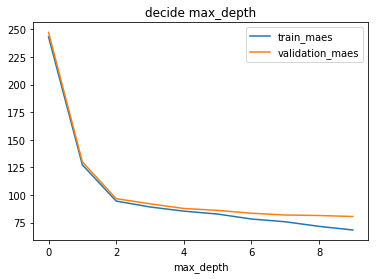

In [25]:
plt.plot(train_maes, label="train_maes")
plt.plot(val_maes, label="validation_maes")
plt.xlabel("max_depth")
plt.title("decide max_depth")
plt.legend()

In [26]:
# ランダムフォレストリグレッサー
# rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = max_depth, max_features=max_features)
rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = 4, max_features=max_features)

rf.fit(X_train, Y_train)
Y_train_pred = rf.predict(X_train)
Y_val_pred = rf.predict(X_val)
print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

train_mae :  87.8785882331
val_mae :  90.426966473


In [27]:
Y_test_pred = rf.predict(X_test)

In [28]:
s_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
e_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
predict_data = pd.DataFrame({"datetime":test_prediction['datetime'][s_idx:e_idx+1]})
predict_data.index = np.arange(len(predict_data))

In [29]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
predict_data["blending_"+str(target_place)] = Y_test_pred

### **扇島発電所について**

In [30]:
target_place = 2

In [31]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]

In [32]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [33]:
# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [34]:
# 月, 時間の情報を加える
train_prediction = add_time_sincos(train_prediction)
test_prediction = add_time_sincos(test_prediction)

In [35]:
len(train_prediction.columns), len(test_prediction.columns)

(25, 25)

In [36]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [37]:
X, Y = drop_nan(X, Y)

In [38]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.3)))

In [39]:
train_maes = []
val_maes = []
for i in range(10):
    rf = RandomForestRegressor(n_estimators = 10, max_depth = i+1, max_features=max_features)
    rf.fit(X_train, Y_train)
    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    train_maes.append(np.abs(Y_train_pred - Y_train).mean())
    val_maes.append(np.abs(Y_val_pred - Y_val).mean())
#     print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
#     print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

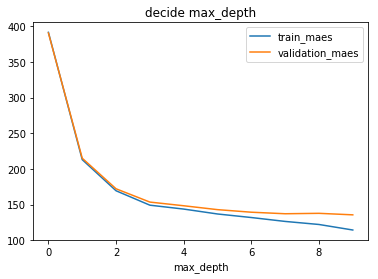

In [40]:
plt.plot(train_maes, label="train_maes")
plt.plot(val_maes, label="validation_maes")
plt.xlabel("max_depth")
plt.title("decide max_depth")
plt.legend()

In [41]:
# ランダムフォレストリグレッサー
rf = RandomForestRegressor(n_estimators = 10, max_depth = 4, max_features=max_features)
rf.fit(X_train, Y_train)
Y_train_pred = rf.predict(X_train)
Y_val_pred = rf.predict(X_val)
print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

train_mae :  148.301059637
val_mae :  153.129295683


In [42]:
Y_test_pred = rf.predict(X_test)

In [43]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
predict_data["blending_"+str(target_place)] = Y_test_pred

### **米倉山発電所について**

In [44]:
target_place = 3

In [45]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]

In [46]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [47]:
# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [48]:
# 月, 時間の情報を加える
train_prediction = add_time_sincos(train_prediction)
test_prediction = add_time_sincos(test_prediction)

In [49]:
len(train_prediction.columns), len(train_prediction.columns)

(25, 25)

In [50]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [51]:
X, Y = drop_nan(X, Y)

In [52]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.3)))

In [53]:
train_maes = []
val_maes = []
for i in range(10):
    rf = RandomForestRegressor(n_estimators = 10, max_depth = i+1, max_features=max_features)
    rf.fit(X_train, Y_train)
    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    train_maes.append(np.abs(Y_train_pred - Y_train).mean())
    val_maes.append(np.abs(Y_val_pred - Y_val).mean())
#     print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
#     print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

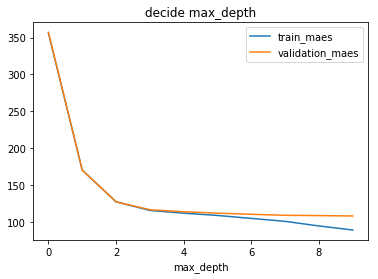

In [54]:
plt.plot(train_maes, label="train_maes")
plt.plot(val_maes, label="validation_maes")
plt.xlabel("max_depth")
plt.title("decide max_depth")
plt.legend()

In [55]:
# ランダムフォレストリグレッサー
rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = 4, max_features=max_features)
rf.fit(X_train, Y_train)
Y_train_pred = rf.predict(X_train)
Y_val_pred = rf.predict(X_val)
print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

train_mae :  118.339154157
val_mae :  118.906755957


In [56]:
Y_test_pred = rf.predict(X_test)

In [57]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
predict_data["blending_"+str(target_place)] = Y_test_pred

### **書き出す**

In [58]:
predict_data.to_csv('data/predicted_data/simple_blending_prediction.tsv', sep = '\t', index=False)

### 線形モデルでやってみる

In [198]:
 from sklearn.preprocessing import StandardScaler

### **浮島**

In [413]:
target_place = 1

In [414]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]

In [415]:
# 太陽電池の劣化に対応するためのスケーリング(必要かどうかはわからない)
# 米倉山は欠損地が多いのでこれには適さない
if target_place == 1 or target_place == 2:
    output_30['year'] = output_30['datetime'].map(lambda x : x.year)
    y_output = output_30.groupby(['year'], as_index=False).sum()
    sum_2012 = y_output["SOLA0"+str(target_place)][0]
    sum_2013 = y_output["SOLA0"+str(target_place)][1]
    sum_2014 = y_output["SOLA0"+str(target_place)][2]
    sum_2015 = y_output["SOLA0"+str(target_place)][3]
    scaled_2012 = np.array(output_30[output_30['year'] == 2012]["SOLA0"+str(target_place)].map(lambda x : x * sum_2015/sum_2012))
    scaled_2013 = np.array(output_30[output_30['year'] == 2013]["SOLA0"+str(target_place)].map(lambda x : x * sum_2015/sum_2013))
    scaled_2014 = np.array(output_30[output_30['year'] == 2014]["SOLA0"+str(target_place)].map(lambda x : x * sum_2015/sum_2014))
    scaled_2015 = np.array(output_30[output_30['year'] == 2015]["SOLA0"+str(target_place)])
    tmp = np.r_[scaled_2012, scaled_2013, scaled_2014, scaled_2015]
    output_30["SOLA0"+str(target_place)] = tmp

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [416]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

'''
# 限られたモデルだけを使う
keys = ["targetplace_"+str(target_place)+"_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds",
        "targetplace_"+str(target_place)+"_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds",
        "targetplace_"+str(target_place)+"_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds"]

keys.append("datetime")
train_prediction = train_prediction[keys]
'''

# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

# test_prediction = test_prediction[keys]

In [417]:
train_prediction.columns

Index(['datetime', 'targetplace_1_kwh_fc_one_layer_2000',
       'targetplace_1_kwh_fc_one_layer_3000',
       'targetplace_1_kwh_fc_one_layer_4000',
       'targetplace_1_kwh_fc_one_layer_5000',
       'targetplace_1_kwh_fc_month_one_layer_1000',
       'targetplace_1_kwh_fc_month_one_layer_2000',
       'targetplace_1_kwh_fc_month_one_layer_3000',
       'targetplace_1_kwh_fc_month_one_layer_4000',
       'targetplace_1_kwh_fc_month_one_layer_5000',
       'targetplace_1_kwh_fc_with_wc_month_one_layer_1000',
       'targetplace_1_kwh_fc_with_wc_month_one_layer_2000',
       'targetplace_1_kwh_fc_with_wc_month_one_layer_3000',
       'targetplace_1_kwh_fc_with_wc_month_one_layer_4000',
       'targetplace_1_kwh_fc_with_wc_month_one_layer_5000',
       'targetplace_1_kwh_all_wfc_month_one_layer_1000',
       'targetplace_1_kwh_all_wfc_month_one_layer_2000',
       'targetplace_1_kwh_all_wfc_month_one_layer_3000',
       'targetplace_1_kwh_all_wfc_month_one_layer_4000',
       'targetpl

In [419]:
test_prediction.columns

Index(['datetime', 'targetplace_1_kwh_fc_one_layer_2000',
       'targetplace_1_kwh_fc_one_layer_3000',
       'targetplace_1_kwh_fc_one_layer_4000',
       'targetplace_1_kwh_fc_one_layer_5000',
       'targetplace_1_kwh_fc_month_one_layer_1000',
       'targetplace_1_kwh_fc_month_one_layer_2000',
       'targetplace_1_kwh_fc_month_one_layer_3000',
       'targetplace_1_kwh_fc_month_one_layer_4000',
       'targetplace_1_kwh_fc_month_one_layer_5000',
       'targetplace_1_kwh_fc_with_wc_month_one_layer_1000',
       'targetplace_1_kwh_fc_with_wc_month_one_layer_2000',
       'targetplace_1_kwh_fc_with_wc_month_one_layer_3000',
       'targetplace_1_kwh_fc_with_wc_month_one_layer_4000',
       'targetplace_1_kwh_fc_with_wc_month_one_layer_5000',
       'targetplace_1_kwh_all_wfc_month_one_layer_1000',
       'targetplace_1_kwh_all_wfc_month_one_layer_2000',
       'targetplace_1_kwh_all_wfc_month_one_layer_3000',
       'targetplace_1_kwh_all_wfc_month_one_layer_4000',
       'targetpl

In [420]:
len(train_prediction.columns), len(test_prediction.columns)

(26, 26)

In [421]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [422]:
X, Y = drop_nan(X, Y)

In [423]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.3)))

In [424]:
# 線形回帰
lin_model = linear_model.LinearRegression(fit_intercept=False)
lin_model.fit(X_train, Y_train)
Y_train_pred = lin_model.predict(X_train)
Y_val_pred = lin_model.predict(X_val)
print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

train_mae :  80.2291914033
val_mae :  81.6399148475


In [425]:
Y_test_pred = lin_model.predict(X_test)

In [426]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
predict_data["blending_"+str(target_place)] = Y_test_pred

### **扇島**

In [427]:
target_place = 2

In [428]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]

# 太陽電池の劣化に対応するためのスケーリング(必要かどうかはわからない)
# 米倉山は欠損地が多いのでこれには適さない
if target_place == 1 or target_place == 2:
    output_30['year'] = output_30['datetime'].map(lambda x : x.year)
    y_output = output_30.groupby(['year'], as_index=False).sum()
    sum_2012 = y_output["SOLA0"+str(target_place)][0]
    sum_2013 = y_output["SOLA0"+str(target_place)][1]
    sum_2014 = y_output["SOLA0"+str(target_place)][2]
    sum_2015 = y_output["SOLA0"+str(target_place)][3]
    scaled_2012 = np.array(output_30[output_30['year'] == 2012]["SOLA0"+str(target_place)].map(lambda x : x * sum_2015/sum_2012))
    scaled_2013 = np.array(output_30[output_30['year'] == 2013]["SOLA0"+str(target_place)].map(lambda x : x * sum_2015/sum_2013))
    scaled_2014 = np.array(output_30[output_30['year'] == 2014]["SOLA0"+str(target_place)].map(lambda x : x * sum_2015/sum_2014))
    scaled_2015 = np.array(output_30[output_30['year'] == 2015]["SOLA0"+str(target_place)])
    tmp = np.r_[scaled_2012, scaled_2013, scaled_2014, scaled_2015]
    output_30["SOLA0"+str(target_place)] = tmp

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [429]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

'''
# 限られたモデルだけを使う
keys = ["targetplace_"+str(target_place)+"_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds",
        "targetplace_"+str(target_place)+"_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds",
        "targetplace_"+str(target_place)+"_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds"]

keys.append("datetime")
train_prediction = train_prediction[keys]
'''

# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

# test_prediction = test_prediction[keys]

In [430]:
train_prediction.columns

Index(['datetime', 'targetplace_2_kwh_fc_one_layer_2000',
       'targetplace_2_kwh_fc_one_layer_3000',
       'targetplace_2_kwh_fc_one_layer_4000',
       'targetplace_2_kwh_fc_one_layer_5000',
       'targetplace_2_kwh_fc_month_one_layer_1000',
       'targetplace_2_kwh_fc_month_one_layer_2000',
       'targetplace_2_kwh_fc_month_one_layer_3000',
       'targetplace_2_kwh_fc_month_one_layer_4000',
       'targetplace_2_kwh_fc_month_one_layer_5000',
       'targetplace_2_kwh_fc_with_wc_month_one_layer_1000',
       'targetplace_2_kwh_fc_with_wc_month_one_layer_2000',
       'targetplace_2_kwh_fc_with_wc_month_one_layer_3000',
       'targetplace_2_kwh_fc_with_wc_month_one_layer_4000',
       'targetplace_2_kwh_fc_with_wc_month_one_layer_5000',
       'targetplace_2_kwh_all_wfc_month_one_layer_1000',
       'targetplace_2_kwh_all_wfc_month_one_layer_2000',
       'targetplace_2_kwh_all_wfc_month_one_layer_3000',
       'targetplace_2_kwh_all_wfc_month_one_layer_4000',
       'targetpl

In [431]:
test_prediction.columns

Index(['datetime', 'targetplace_2_kwh_fc_one_layer_2000',
       'targetplace_2_kwh_fc_one_layer_3000',
       'targetplace_2_kwh_fc_one_layer_4000',
       'targetplace_2_kwh_fc_one_layer_5000',
       'targetplace_2_kwh_fc_month_one_layer_1000',
       'targetplace_2_kwh_fc_month_one_layer_2000',
       'targetplace_2_kwh_fc_month_one_layer_3000',
       'targetplace_2_kwh_fc_month_one_layer_4000',
       'targetplace_2_kwh_fc_month_one_layer_5000',
       'targetplace_2_kwh_fc_with_wc_month_one_layer_1000',
       'targetplace_2_kwh_fc_with_wc_month_one_layer_2000',
       'targetplace_2_kwh_fc_with_wc_month_one_layer_3000',
       'targetplace_2_kwh_fc_with_wc_month_one_layer_4000',
       'targetplace_2_kwh_fc_with_wc_month_one_layer_5000',
       'targetplace_2_kwh_all_wfc_month_one_layer_1000',
       'targetplace_2_kwh_all_wfc_month_one_layer_2000',
       'targetplace_2_kwh_all_wfc_month_one_layer_3000',
       'targetplace_2_kwh_all_wfc_month_one_layer_4000',
       'targetpl

In [432]:
len(train_prediction.columns), len(test_prediction.columns)

(23, 23)

In [433]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [434]:
X, Y = drop_nan(X, Y)

In [435]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.3)))

In [436]:
# 線形モデル
lin_model = linear_model.LinearRegression(fit_intercept=False)
lin_model.fit(X_train, Y_train)
Y_train_pred = lin_model.predict(X_train)
Y_val_pred = lin_model.predict(X_val)
print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

train_mae :  128.578394173
val_mae :  130.003303146


In [437]:
Y_test_pred = lin_model.predict(X_test)

In [438]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
predict_data["blending_"+str(target_place)] = Y_test_pred

### **米倉山**

In [439]:
target_place = 3

In [440]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]

In [441]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

'''
# 限られたモデルだけを使う
keys = ["targetplace_"+str(target_place)+"_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds",
        "targetplace_"+str(target_place)+"_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds",
        "targetplace_"+str(target_place)+"_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds"]

keys.append("datetime")
train_prediction = train_prediction[keys]
'''

# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

# test_prediction = test_prediction[keys]

In [442]:
train_prediction.columns

Index(['datetime', 'targetplace_3_kwh_fc_one_layer_2000',
       'targetplace_3_kwh_fc_one_layer_3000',
       'targetplace_3_kwh_fc_one_layer_4000',
       'targetplace_3_kwh_fc_one_layer_5000',
       'targetplace_3_kwh_fc_month_one_layer_1000',
       'targetplace_3_kwh_fc_month_one_layer_2000',
       'targetplace_3_kwh_fc_month_one_layer_3000',
       'targetplace_3_kwh_fc_month_one_layer_4000',
       'targetplace_3_kwh_fc_month_one_layer_5000',
       'targetplace_3_kwh_fc_with_wc_month_one_layer_1000',
       'targetplace_3_kwh_fc_with_wc_month_one_layer_2000',
       'targetplace_3_kwh_fc_with_wc_month_one_layer_3000',
       'targetplace_3_kwh_fc_with_wc_month_one_layer_4000',
       'targetplace_3_kwh_fc_with_wc_month_one_layer_5000',
       'targetplace_3_kwh_all_wfc_month_one_layer_1000',
       'targetplace_3_kwh_all_wfc_month_one_layer_2000',
       'targetplace_3_kwh_all_wfc_month_one_layer_3000',
       'targetplace_3_kwh_all_wfc_month_one_layer_4000',
       'targetpl

In [443]:
test_prediction.columns

Index(['datetime', 'targetplace_3_kwh_fc_one_layer_2000',
       'targetplace_3_kwh_fc_one_layer_3000',
       'targetplace_3_kwh_fc_one_layer_4000',
       'targetplace_3_kwh_fc_one_layer_5000',
       'targetplace_3_kwh_fc_month_one_layer_1000',
       'targetplace_3_kwh_fc_month_one_layer_2000',
       'targetplace_3_kwh_fc_month_one_layer_3000',
       'targetplace_3_kwh_fc_month_one_layer_4000',
       'targetplace_3_kwh_fc_month_one_layer_5000',
       'targetplace_3_kwh_fc_with_wc_month_one_layer_1000',
       'targetplace_3_kwh_fc_with_wc_month_one_layer_2000',
       'targetplace_3_kwh_fc_with_wc_month_one_layer_3000',
       'targetplace_3_kwh_fc_with_wc_month_one_layer_4000',
       'targetplace_3_kwh_fc_with_wc_month_one_layer_5000',
       'targetplace_3_kwh_all_wfc_month_one_layer_1000',
       'targetplace_3_kwh_all_wfc_month_one_layer_2000',
       'targetplace_3_kwh_all_wfc_month_one_layer_3000',
       'targetplace_3_kwh_all_wfc_month_one_layer_4000',
       'targetpl

In [444]:
len(train_prediction.columns), len(test_prediction.columns)

(23, 23)

In [445]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [446]:
X, Y = drop_nan(X, Y)

In [447]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.3)))

In [448]:
# 線形モデル
lin_model = linear_model.LinearRegression(fit_intercept=False)
lin_model.fit(X_train, Y_train)
Y_train_pred = lin_model.predict(X_train)
Y_val_pred = lin_model.predict(X_val)
print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

train_mae :  108.715749969
val_mae :  107.025771609


In [449]:
Y_test_pred = lin_model.predict(X_test)

In [450]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
predict_data["blending_"+str(target_place)] = Y_test_pred

### **書き出す**

In [451]:
predict_data["blending_1"] = predict_data["blending_1"].map(lambda x: minus_to_zero(x))
predict_data["blending_2"] = predict_data["blending_2"].map(lambda x: minus_to_zero(x))
predict_data["blending_3"] = predict_data["blending_3"].map(lambda x: minus_to_zero(x))

In [452]:
predict_data.to_csv('data/predicted_data/simple_blending_prediction.tsv', sep = '\t', index=False)

### **特定のモデルを書き出す**

In [292]:
target_place = 1

In [293]:
# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [175]:
test_prediction.columns

Index(['datetime', 'targetplace_1_kwh_fc_one_layer_2000',
       'targetplace_1_kwh_fc_one_layer_3000',
       'targetplace_1_kwh_fc_one_layer_4000',
       'targetplace_1_kwh_fc_one_layer_5000',
       'targetplace_1_kwh_fc_month_one_layer_1000',
       'targetplace_1_kwh_fc_month_one_layer_2000',
       'targetplace_1_kwh_fc_month_one_layer_3000',
       'targetplace_1_kwh_fc_month_one_layer_4000',
       'targetplace_1_kwh_fc_month_one_layer_5000',
       'targetplace_1_kwh_fc_with_wc_month_one_layer_1000',
       'targetplace_1_kwh_fc_with_wc_month_one_layer_2000',
       'targetplace_1_kwh_fc_with_wc_month_one_layer_3000',
       'targetplace_1_kwh_fc_with_wc_month_one_layer_4000',
       'targetplace_1_kwh_fc_with_wc_month_one_layer_5000',
       'targetplace_1_kwh_all_wfc_month_one_layer_1000',
       'targetplace_1_kwh_all_wfc_month_one_layer_2000',
       'targetplace_1_kwh_all_wfc_month_one_layer_3000',
       'targetplace_1_kwh_all_wfc_month_one_layer_4000',
       'targetpl

In [181]:
keys = ["targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds",
        "targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds",
        "targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds"]
tmp = test_prediction[keys]
tmp = tmp.mean(axis=1)

In [182]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
predict_data["blending_"+str(target_place)] = tmp

In [183]:
target_place = 2

In [184]:
# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [185]:
test_prediction.columns

Index(['datetime', 'targetplace_2_kwh_fc_one_layer_2000',
       'targetplace_2_kwh_fc_one_layer_3000',
       'targetplace_2_kwh_fc_one_layer_4000',
       'targetplace_2_kwh_fc_one_layer_5000',
       'targetplace_2_kwh_fc_month_one_layer_1000',
       'targetplace_2_kwh_fc_month_one_layer_2000',
       'targetplace_2_kwh_fc_month_one_layer_3000',
       'targetplace_2_kwh_fc_month_one_layer_4000',
       'targetplace_2_kwh_fc_month_one_layer_5000',
       'targetplace_2_kwh_fc_with_wc_month_one_layer_1000',
       'targetplace_2_kwh_fc_with_wc_month_one_layer_2000',
       'targetplace_2_kwh_fc_with_wc_month_one_layer_3000',
       'targetplace_2_kwh_fc_with_wc_month_one_layer_4000',
       'targetplace_2_kwh_fc_with_wc_month_one_layer_5000',
       'targetplace_2_kwh_all_wfc_month_one_layer_1000',
       'targetplace_2_kwh_all_wfc_month_one_layer_2000',
       'targetplace_2_kwh_all_wfc_month_one_layer_3000',
       'targetplace_2_kwh_all_wfc_month_one_layer_4000',
       'targetpl

In [186]:
keys = ["targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds",
        "targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds",
        "targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds"]
tmp = test_prediction[keys]
tmp = tmp.mean(axis=1)

In [187]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
predict_data["blending_"+str(target_place)] = tmp

In [188]:
target_place = 3

In [189]:
# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [190]:
test_prediction.columns

Index(['datetime', 'targetplace_3_kwh_fc_one_layer_2000',
       'targetplace_3_kwh_fc_one_layer_3000',
       'targetplace_3_kwh_fc_one_layer_4000',
       'targetplace_3_kwh_fc_one_layer_5000',
       'targetplace_3_kwh_fc_month_one_layer_1000',
       'targetplace_3_kwh_fc_month_one_layer_2000',
       'targetplace_3_kwh_fc_month_one_layer_3000',
       'targetplace_3_kwh_fc_month_one_layer_4000',
       'targetplace_3_kwh_fc_month_one_layer_5000',
       'targetplace_3_kwh_fc_with_wc_month_one_layer_1000',
       'targetplace_3_kwh_fc_with_wc_month_one_layer_2000',
       'targetplace_3_kwh_fc_with_wc_month_one_layer_3000',
       'targetplace_3_kwh_fc_with_wc_month_one_layer_4000',
       'targetplace_3_kwh_fc_with_wc_month_one_layer_5000',
       'targetplace_3_kwh_all_wfc_month_one_layer_1000',
       'targetplace_3_kwh_all_wfc_month_one_layer_2000',
       'targetplace_3_kwh_all_wfc_month_one_layer_3000',
       'targetplace_3_kwh_all_wfc_month_one_layer_4000',
       'targetpl

In [191]:
keys = ["targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds",
        "targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds",
        "targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds"]
tmp = test_prediction[keys]
tmp = tmp.mean(axis=1)

In [192]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
predict_data["blending_"+str(target_place)] = tmp

In [193]:
def minus_to_zero(x):
    if x < 0:
        return 0
    else:
        return x

In [194]:
predict_data["blending_1"] = predict_data["blending_1"].map(lambda x: minus_to_zero(x))
predict_data["blending_2"] = predict_data["blending_2"].map(lambda x: minus_to_zero(x))
predict_data["blending_3"] = predict_data["blending_3"].map(lambda x: minus_to_zero(x))

In [196]:
predict_data

,datetime,blending_1,blending_2,blending_3
0,2016-01-01 00:00:00,0.000000,0.000000,0.000000
1,2016-01-01 00:30:00,0.000000,0.000000,0.000000
2,2016-01-01 01:00:00,0.000000,0.000000,0.000000
3,2016-01-01 01:30:00,0.000000,0.000000,0.000000
4,2016-01-01 02:00:00,0.000000,0.000000,0.000000
5,2016-01-01 02:30:00,0.000000,0.000000,0.000000
6,2016-01-01 03:00:00,0.000000,0.000000,0.000000
7,2016-01-01 03:30:00,0.000000,0.000000,0.000000
8,2016-01-01 04:00:00,0.000000,0.000000,0.000000
9,2016-01-01 04:30:00,0.000000,0.000000,0.000000


In [197]:
predict_data.to_csv('data/predicted_data/simple_blending_prediction.tsv', sep = '\t', index=False)